In [1]:
import os
import timm
import json
import torch
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import torch.optim as optim
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
GLOBAL_SEED=123
np.random.seed(GLOBAL_SEED)

In [3]:
kaggle_root = Path('/kaggle/input')
dataset_root = kaggle_root / 'imaterialist-fashion-2020-fgvc7'
models_root = kaggle_root / 'saved-models-imaterialist-embedding-extraction'
train_df_path = dataset_root / 'train.csv'
# images_folder = dataset_root / 'train'
images_folder = kaggle_root / 'imaterialist-train-224x224' / 'train_224'
desc_path = dataset_root / 'label_descriptions.json'

In [4]:
full_dataset_df = pd.read_csv(train_df_path)

In [5]:
full_dataset_groupped = full_dataset_df[
    ['ImageId', 'ClassId']
].groupby('ImageId')[
    'ClassId'
].agg([('ClassIds', lambda xs: set(xs))])

In [6]:
N_CLASSES=len(set(full_dataset_df['ClassId']))
print("Number of classes: ", N_CLASSES)

Number of classes:  46


In [7]:
class_descriptions = json.load(open(desc_path))
class_descriptions = list(map(lambda x: x[1], sorted(list(map(
    lambda x: (x['id'], x['name']),
    class_descriptions['categories']
)), key=lambda x: x[0])))
class_descriptions = np.array(class_descriptions)

In [8]:
class FashionDatasetSS(Dataset):
    def __init__(
            self,
            dataframe,
            image_folder,
            n_classes=N_CLASSES,
            transform=None,
        ):
        self.dataframe: pd.DataFrame = dataframe
        self.image_folder: Path = image_folder
        self.transform: nn.Module = transform
        self.n_classes: int = n_classes
            
    def __len__(self):
        return len(self.dataframe)
    
    def load_transform(self, image_id):
        image = Image.open(self.image_folder / f"{image_id}.jpg")
        if image.mode == 'L':
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

    def __getitem__(self, i):
        anchor_image_id = self.dataframe.iloc[i].name
        
        pos_1 = self.load_transform(anchor_image_id)
        pos_2 = self.load_transform(anchor_image_id)

        return pos_1, pos_2

In [9]:
class FashionDataset(Dataset):
    def __init__(
            self,
            dataframe,
            image_folder,
            n_classes=N_CLASSES,
            transform=None,
            positive_match_percent=0.8,
            seed_with=None,
            cache_n=None,
        ):
        self.dataframe: pd.DataFrame = dataframe
        self.image_folder: Path = image_folder
        self.transform: nn.Module = transform
        self.n_classes: int = n_classes
        self.labels_images = self.create_label_to_image_series()
        self.positive_match_percent: float = positive_match_percent
        self.all_classes = set(np.arange(n_classes))
        self.seed_with = seed_with
        self.cache_n = cache_n
        self.cached_matches_dict = {}
        if seed_with is not None:
            np.random.seed(seed_with)
        if cache_n is not None:
            print("Caching...")
            for i in range(len(self.dataframe)):
                self.update_matches_at_i(i)
                if i % 100 == 0: print(f"{i} / {len(self.dataframe)}")
    
    def update_matches_at_i(self, i):
        anchor_image_id = self.dataframe.iloc[i].name
        anchor_labels = self.dataframe.iloc[i]['ClassIds']
        
        potential_positives_v_cts = self.labels_images[list(anchor_labels)].explode().value_counts()

        pos_mask = potential_positives_v_cts >= (
            self.positive_match_percent * len(anchor_labels)
        )
        positive_image_is = list(np.random.choice(np.where(pos_mask)[0], self.cache_n))
        positive_image_ids = potential_positives_v_cts.iloc[positive_image_is].index.tolist()

        neg_mask = ((anchor_labels - self.dataframe["ClassIds"]).apply(len) == len(anchor_labels))
        negative_image_is = np.random.choice(np.where(neg_mask)[0], self.cache_n)
        negative_image_ids = self.dataframe.iloc[negative_image_is].index.tolist()

        self.cached_matches_dict[i] = (positive_image_ids, negative_image_ids)

    def __len__(self):
        return len(self.dataframe)

    def create_label_to_image_series(self) -> pd.Series:
        """Regroup by ClassId for quick access in the future"""
        return self.dataframe.explode("ClassIds").groupby("ClassIds").apply(
            lambda x: set(x.index)
        )
    
    def load_transform(self, image_id):
        image = Image.open(self.image_folder / f"{image_id}.jpg")
        if image.mode == 'L':
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_positive_negative(self, anchor_labels):
        potential_positives_v_cts = self.labels_images[list(anchor_labels)].explode().value_counts()

        pos_mask = potential_positives_v_cts >= (
            self.positive_match_percent * len(anchor_labels)
        )
        positive_image_i = np.random.choice(np.where(pos_mask)[0])
        positive_image_id = potential_positives_v_cts.iloc[[positive_image_i]].index[0]

        neg_mask = ((anchor_labels - self.dataframe["ClassIds"]).apply(len) == len(anchor_labels))
        negative_image_i = np.random.choice(np.where(neg_mask)[0])
        negative_image_id = self.dataframe.iloc[negative_image_i].name

        return positive_image_id, negative_image_id

    def __getitem__(self, idx):
        if idx == 0 and self.seed_with is not None:
            np.random.seed(self.seed_with)

        anchor_image_id = self.dataframe.iloc[idx].name
        
        if self.cache_n is None:
            anchor_labels = self.dataframe.iloc[idx]['ClassIds']
            positive_image_id, negative_image_id = self.get_positive_negative(anchor_labels)
        else:
            positive_image_id = self.cached_matches_dict[idx][0].pop()
            negative_image_id = self.cached_matches_dict[idx][1].pop()

        anchor_image = self.load_transform(anchor_image_id)
        positive_image = self.load_transform(positive_image_id)
        negative_image = self.load_transform(negative_image_id)

        return anchor_image, positive_image, negative_image

In [10]:
train_df, test_df = train_test_split(
    full_dataset_groupped,
    test_size=0.2,
    random_state=GLOBAL_SEED,
)

In [11]:
input_size = 224

train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(input_size, scale=(0.33, 1)),
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_ss = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

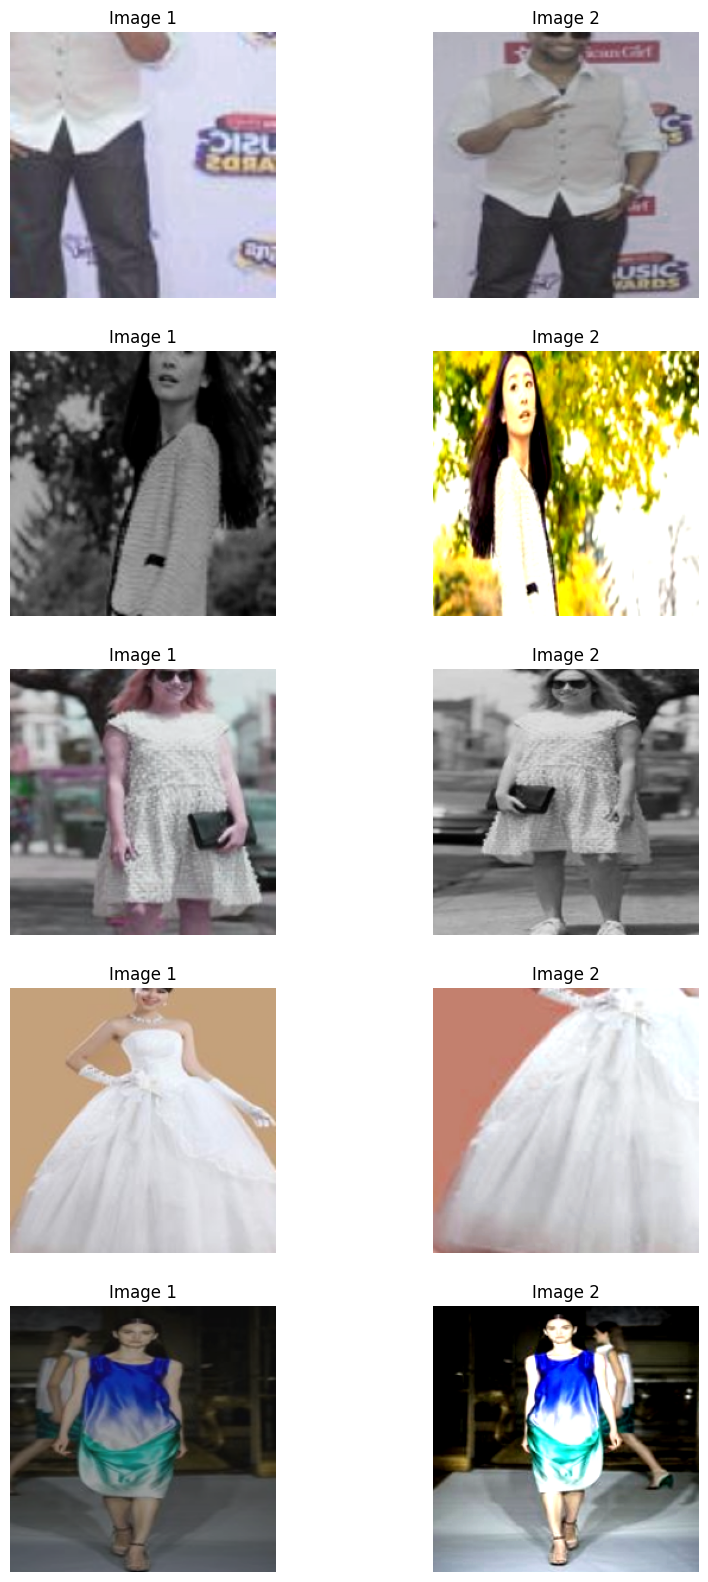

In [12]:
def denorm(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for channel in range(3):
        image[channel] *= std[channel]
        image[channel] += mean[channel]
    return image.permute(1, 2, 0)
    

tds = FashionDatasetSS(train_df, images_folder, transform=train_transform_ss)
n = 5
fig, axes = plt.subplots(n, 2, figsize=(n*2, 10*2))
for i, ax_row in enumerate(axes):
    pos_1, pos_2 = tds[i]
    ax_row[0].imshow(denorm(pos_1))
    ax_row[0].set_title("Image 1")
    ax_row[0].axis('off')
    ax_row[1].imshow(denorm(pos_2))
    ax_row[1].set_title("Image 2")
    ax_row[1].axis('off')
plt.show()

In [13]:
N_EPOCHS=20

In [14]:
train_dataset = FashionDatasetSS(train_df, images_folder, transform=train_transform_ss)
test_dataset = FashionDataset(test_df, images_folder, transform=test_transform, seed_with=GLOBAL_SEED, cache_n=N_EPOCHS)

Caching...
0 / 9125
100 / 9125
200 / 9125
300 / 9125
400 / 9125
500 / 9125
600 / 9125
700 / 9125
800 / 9125
900 / 9125
1000 / 9125
1100 / 9125
1200 / 9125
1300 / 9125
1400 / 9125
1500 / 9125
1600 / 9125
1700 / 9125
1800 / 9125
1900 / 9125
2000 / 9125
2100 / 9125
2200 / 9125
2300 / 9125
2400 / 9125
2500 / 9125
2600 / 9125
2700 / 9125
2800 / 9125
2900 / 9125
3000 / 9125
3100 / 9125
3200 / 9125
3300 / 9125
3400 / 9125
3500 / 9125
3600 / 9125
3700 / 9125
3800 / 9125
3900 / 9125
4000 / 9125
4100 / 9125
4200 / 9125
4300 / 9125
4400 / 9125
4500 / 9125
4600 / 9125
4700 / 9125
4800 / 9125
4900 / 9125
5000 / 9125
5100 / 9125
5200 / 9125
5300 / 9125
5400 / 9125
5500 / 9125
5600 / 9125
5700 / 9125
5800 / 9125
5900 / 9125
6000 / 9125
6100 / 9125
6200 / 9125
6300 / 9125
6400 / 9125
6500 / 9125
6600 / 9125
6700 / 9125
6800 / 9125
6900 / 9125
7000 / 9125
7100 / 9125
7200 / 9125
7300 / 9125
7400 / 9125
7500 / 9125
7600 / 9125
7700 / 9125
7800 / 9125
7900 / 9125
8000 / 9125
8100 / 9125
8200 / 9125
8300 

In [15]:
BATCH_SIZE=32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [16]:
model = timm.create_model('swin_small_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
# model.head.fc = nn.Linear(model.head.fc.in_features, N_CLASSES)
model.head.fc = nn.Identity()

In [18]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

In [20]:
SKIP_EPOCHS = 0 # based on model
# small_trainedhead_path = models_root / 'last_layer_trained_small_swin_ep1_best5237.pth'
# model.load_state_dict(torch.load(small_trainedhead_path, map_location=device))

In [21]:
n_params, n_trained = 0, 0
for name, params in model.named_parameters():
    if 'layers' in name and int(name.split('.')[1]) < 3:
        params.requires_grad = False
#         print(f"Removing {name}")
    elif 'patch_embed' in name:
        params.requires_grad = False
#         print(f"Removing {name}")
    else:
        params.requires_grad = True
        n_trained += params.numel()
        print(f"Keeping {name}")
    n_params += params.numel()
    
print(f"Training {n_trained}/{n_params} ({n_trained/n_params*100:.2f}%)")

Keeping layers.3.downsample.norm.weight
Keeping layers.3.downsample.norm.bias
Keeping layers.3.downsample.reduction.weight
Keeping layers.3.blocks.0.norm1.weight
Keeping layers.3.blocks.0.norm1.bias
Keeping layers.3.blocks.0.attn.relative_position_bias_table
Keeping layers.3.blocks.0.attn.qkv.weight
Keeping layers.3.blocks.0.attn.qkv.bias
Keeping layers.3.blocks.0.attn.proj.weight
Keeping layers.3.blocks.0.attn.proj.bias
Keeping layers.3.blocks.0.norm2.weight
Keeping layers.3.blocks.0.norm2.bias
Keeping layers.3.blocks.0.mlp.fc1.weight
Keeping layers.3.blocks.0.mlp.fc1.bias
Keeping layers.3.blocks.0.mlp.fc2.weight
Keeping layers.3.blocks.0.mlp.fc2.bias
Keeping layers.3.blocks.1.norm1.weight
Keeping layers.3.blocks.1.norm1.bias
Keeping layers.3.blocks.1.attn.relative_position_bias_table
Keeping layers.3.blocks.1.attn.qkv.weight
Keeping layers.3.blocks.1.attn.qkv.bias
Keeping layers.3.blocks.1.attn.proj.weight
Keeping layers.3.blocks.1.attn.proj.bias
Keeping layers.3.blocks.1.norm2.weigh

In [22]:
# skipping this step
# embedding_dim, feature_dim = 768, 128
# out_model = nn.Sequential(
#     nn.Linear(embedding_dim, 256, bias=False),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, feature_dim, bias=True)
# )

In [23]:
def train(model, dataloader, criterion, optimizer, device, temperature=0.5, stop_i=None):
    model.train()
    total_loss, total_num, tqdm_dl = 0.0, 0, tqdm(dataloader)
    for i, (pos_1, pos_2) in enumerate(tqdm_dl):
        pos_1, pos_2 = pos_1.to(device, non_blocking=True), pos_2.to(device, non_blocking=True)
        out_1 = model(pos_1)
        out_2 = model(pos_2)

        bs = out_1.shape[0]

        out = torch.cat([out_1, out_2], dim=0)
        sim_matrix: torch.Tensor = torch.mm(out, out.t().contiguous()) / temperature

        diff_emb_mask = (torch.ones_like(
            sim_matrix
        ) - torch.eye(
            sim_matrix.shape[0], device=sim_matrix.device
        )).bool()

        sim_matrix = sim_matrix.masked_select(
            diff_emb_mask
        ).view(sim_matrix.shape[0], -1)

        sim_targets = (torch.arange(2*bs)+bs)%(2*bs) - torch.cat([torch.ones(bs, dtype=torch.int64), torch.zeros(bs, dtype=torch.int64)], dim=0)
        sim_targets = sim_targets.to(device)
        
        loss = criterion(sim_matrix, sim_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_num += out_1.shape[0]
        total_loss += loss.item() * out_1.shape[0]
        
        if stop_i is not None and i > stop_i: break

    return total_loss / total_num

In [24]:
def test(model, dataloader, criterion, device, stop_i=None):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(tqdm(dataloader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            total_loss += loss.item()

            correct_predictions += (
                (anchor_embed - positive_embed).pow(2).sum(1) <
                (anchor_embed - negative_embed).pow(2).sum(1)
            ).sum().item()
            total_predictions += anchor.size(0)

            if stop_i is not None and i > stop_i: break

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [25]:
test_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=0.00001)

In [26]:
num_epochs = N_EPOCHS
max_acc = 0
stop_i = None
for epoch in range(num_epochs):
    if epoch < SKIP_EPOCHS:
        print(f"\nSKIPPED: Epoch {epoch+1}/{num_epochs}")
        scheduler.step()
        continue
    train_loss = train(model, train_loader, criterion, optimizer, device, stop_i=stop_i)
    test_loss, test_acc = test(model, test_loader, test_criterion, device, stop_i=stop_i)
    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss (Triplet): {test_loss:.4f}, Test accuracy: {test_acc:.6f}")
    postfix = f'ep{epoch+1}'
    if test_acc > max_acc:
        print("Detected new best test accuracy!")
        max_acc = test_acc
        postfix += f'_best{test_acc*10000:.0f}'
    print("Saving model!")
    torch.save(model.state_dict(), f'/kaggle/working/model_{postfix}.pth')
    scheduler.step()
    print()

100%|██████████| 286/286 [01:57<00:00,  2.43it/s]



Epoch 1/20, Train Loss: 0.2367, Test Loss (Triplet): 0.6731, Test accuracy: 0.707068
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 2/20, Train Loss: 0.1463, Test Loss (Triplet): 0.6565, Test accuracy: 0.726795
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 3/20, Train Loss: 0.1290, Test Loss (Triplet): 0.6734, Test accuracy: 0.714959
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 4/20, Train Loss: 0.1238, Test Loss (Triplet): 0.6884, Test accuracy: 0.713534
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 5/20, Train Loss: 0.1162, Test Loss (Triplet): 0.7097, Test accuracy: 0.691726
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 6/20, Train Loss: 0.1047, Test Loss (Triplet): 0.6839, Test accuracy: 0.714630
Saving model!



100%|██████████| 286/286 [01:56<00:00,  2.44it/s]



Epoch 7/20, Train Loss: 0.1001, Test Loss (Triplet): 0.7181, Test accuracy: 0.686247
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 8/20, Train Loss: 0.0893, Test Loss (Triplet): 0.6952, Test accuracy: 0.704986
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 9/20, Train Loss: 0.0826, Test Loss (Triplet): 0.6856, Test accuracy: 0.714630
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 10/20, Train Loss: 0.0798, Test Loss (Triplet): 0.7500, Test accuracy: 0.667507
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 11/20, Train Loss: 0.0715, Test Loss (Triplet): 0.7412, Test accuracy: 0.671452
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 12/20, Train Loss: 0.0657, Test Loss (Triplet): 0.7990, Test accuracy: 0.632658
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 13/20, Train Loss: 0.0598, Test Loss (Triplet): 0.7732, Test accuracy: 0.650192
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 14/20, Train Loss: 0.0583, Test Loss (Triplet): 0.7412, Test accuracy: 0.677260
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 15/20, Train Loss: 0.0504, Test Loss (Triplet): 0.7544, Test accuracy: 0.664219
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 16/20, Train Loss: 0.0461, Test Loss (Triplet): 0.7742, Test accuracy: 0.653808
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 17/20, Train Loss: 0.0458, Test Loss (Triplet): 0.7567, Test accuracy: 0.666959
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 18/20, Train Loss: 0.0436, Test Loss (Triplet): 0.7634, Test accuracy: 0.663342
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 19/20, Train Loss: 0.0414, Test Loss (Triplet): 0.7637, Test accuracy: 0.662575
Saving model!



100%|██████████| 286/286 [01:57<00:00,  2.44it/s]



Epoch 20/20, Train Loss: 0.0431, Test Loss (Triplet): 0.7674, Test accuracy: 0.660603
Saving model!

